In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [74]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2


def find_js_dist_blowup_max_slope(js_dists: List[float]):
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes
    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    js_dists: List[float], threshold: float = 5e-03, window_size: int = 5
) -> int:

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_dists) - window_size + 1):
        window = js_dists[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(js_dists) - 1


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def plot_heatmap_feature_acts(feature_activations, js_dists):
    # Assuming feature_activations is a PyTorch tensor
    feature_acts_np = (
        feature_activations.numpy()
    )  # Convert to numpy if it's not already

    # Identify top features from start and end
    n_top = 10
    start_top_features = np.argsort(feature_acts_np[0])[-n_top:][::-1]
    end_top_features = np.argsort(feature_acts_np[-1])[-n_top:][::-1]

    # Assume js_blowup_step is the time step where JS distance starts increasing rapidly
    js_blowup_step = find_js_dist_blowup(js_dists)  # Replace with your actual step

    # Combine and get unique features
    combined_features = np.unique(
        np.concatenate([start_top_features, end_top_features])
    )

    # Create labels for y-axis
    y_labels = []

    feature_ranks = []

    for feat in combined_features:
        start_rank = np.where(start_top_features == feat)[0]
        end_rank = np.where(end_top_features == feat)[0]
        feature_rank = 0

        label = f"F{feat}"
        if len(start_rank) > 0:
            label += f" (S-{start_rank[0]+1})"
            feature_rank += start_rank[0]
        else:
            feature_rank += n_top

        if len(end_rank) > 0:
            label += f" (E-{end_rank[0]+1})"
            if len(start_rank) == 0:
                feature_rank += 10 + end_rank[0]

        y_labels.append(label)
        feature_ranks.append(feature_rank)

    sorted_feature_ranks = np.argsort(feature_ranks)
    sorted_y_labels = [y_labels[idx] for idx in sorted_feature_ranks]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, len(combined_features) / 2 + 2))
    sns.heatmap(
        feature_acts_np[:, combined_features[sorted_feature_ranks]].T,
        cmap="coolwarm",
        cbar_kws={"label": "Activation"},
        yticklabels=sorted_y_labels,
        ax=ax,
    )

    # Add vertical line for JS distance blowup
    ax.axvline(x=js_blowup_step, color="white", linestyle="--", linewidth=2)

    # Add text annotation for the JS blowup line
    ax.text(
        js_blowup_step,
        len(combined_features) - 0.25,
        "JS Dist Blowup",
        rotation=90,
        va="bottom",
        ha="right",
        color="white",
        fontweight="normal",
    )

    # Assuming js_distances is your array of JS distances over time
    ax2 = ax.twinx()
    ax2.plot(js_dists, color="white", linewidth=2)
    ax2.set_ylabel("JS Distance", color="white")
    ax2.tick_params(axis="y", labelcolor="white")

    plt.title("Top Feature Activations Over Time (Start and End)")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature ID (Start Rank, End Rank)")
    plt.tight_layout()
    plt.show()

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:26<00:00, 26.66s/it]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Load & Clean data

In [57]:
metadata, activations = [], []

n_files = 5

for path in sorted(glob("observations/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob("observations/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [58]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

In [59]:
# Clean data
clean_metadata = []
clean_activations = []

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

max_recon_error = 3.0
c = 0

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    js_dists = [s["js_dist"] for s in m["steps_metadata"]]

    if js_dists[-1] - js_dists[0] < 0.1:
        continue

    if np.isnan(js_dists).sum() > 1:
        continue

    act_recon = sae.decode(sae.encode(torch.tensor(acts[0])))
    recon_error = torch.tensor(acts[0]) - act_recon
    recon_error = recon_error.abs().sum(dim=-1).detach().numpy()

    if recon_error > max_recon_error:
        continue

    clean_metadata.append(m)
    clean_activations.append(acts)

    c += 1

    if c % 500 == 0:
        print(c)

clean_activations = np.stack(clean_activations)

500
1000
1500
2000
2500
3000


In [60]:
len(clean_metadata), clean_activations.shape

(3392, (3392, 100, 768))

In [61]:
metadata = clean_metadata
activations = clean_activations

## Prediction Function

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import entropy

In [235]:
def find_crossover_point(feature_acts):
    start_feature = feature_acts[:, 0]
    end_feature = feature_acts[:, 1]

    # Compare absolute values
    mask = torch.abs(end_feature) > torch.abs(start_feature)

    # Find the first True value in the mask
    crossover_indices = torch.nonzero(mask)

    if crossover_indices.numel() > 0:
        return crossover_indices[0].item()
    else:
        return feature_acts.shape[0] // 2


def extract_crossover_point(feature_acts):
    top_features_start = torch.argsort(feature_acts[0])[-5:].flip(dims=(0,))
    top_features_end = torch.argsort(feature_acts[-1])[-5:].flip(dims=(0,))
    feature_ids = [top_features_start[0].item(), top_features_end[0].item()]
    crossover_point = find_crossover_point(feature_acts[:, feature_ids])
    return crossover_point


def get_data_for_step(steps):
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup_max_slope(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    feature_acts = get_feature_activations(steps)
    return feature_acts, step_js_dists, js_blowup_step, sensitivity


def get_feature_activations(steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def find_crossover_point_between_vectors(v1, v2):
    for i, (n1, n2) in enumerate(zip(v1, v2)):
        if n1 < n2:
            return i
    return len(v1)


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act

In [165]:
labels = []
preds = []
ind_preds = defaultdict(list)

n_examples = min(100, len(metadata))
idxs = random.sample(range(len(metadata)), n_examples)
# idxs = range(n_examples)

for i, idx in enumerate(idxs):
    steps = metadata[idx]["steps_metadata"]
    feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)
    labels.append(sensitivity)

    # # Find crossover point
    # cp_point = extract_crossover_point(feature_acts)
    # pred_sensitivity_cp = 1 - cp_point / len(steps)

    # Find crossover point
    top_feature_ids_start = torch.argsort(feature_acts[0]).numpy()[::-1][:5].tolist()
    top_feature_acts_start = feature_acts[:, top_feature_ids_start]
    top_feature_acts_norm_start = (
        top_feature_acts_start / top_feature_acts_start.max(dim=0).values
    )
    top_feature_acts_start_mean = top_feature_acts_norm_start.mean(dim=-1)

    top_feature_ids_end = torch.argsort(feature_acts[-1]).numpy()[::-1][:5].tolist()
    top_feature_acts_end = feature_acts[:, top_feature_ids_end]
    top_feature_acts_norm_end = (
        top_feature_acts_end / top_feature_acts_end.max(dim=0).values
    )
    top_feature_acts_end_mean = top_feature_acts_norm_end.mean(dim=-1)

    cp_point_mean_feats = find_crossover_point_between_vectors(
        top_feature_acts_start_mean, top_feature_acts_end_mean
    )
    pred_sensitivity_cp_mean = 1 - cp_point_mean_feats / len(steps)

    # # Find max acceleration
    # row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
    # top_features_per_step = np.argsort(feature_acts)[:, -5:]
    # top_features_acts = feature_acts[row_indices, top_features_per_step]

    # gradients = np.gradient(top_features_acts, axis=0)
    # accelerations = np.gradient(gradients, axis=0)

    # max_gradient = np.max(np.abs(accelerations), axis=1)
    # pred_step = np.argsort(max_gradient)[::-1][0]
    # pred_sensitivity_acc = 1 - pred_step / len(steps)

    # pred_sensitivity = np.mean([pred_sensitivity_cp, pred_sensitivity_acc])
    pred_sensitivity = pred_sensitivity_cp_mean

    # ind_preds['pred_sensitivity_cp'].append(pred_sensitivity_cp)
    # ind_preds['pred_sensitivity_acc'].append(pred_sensitivity_acc)

    preds.append(pred_sensitivity)

In [166]:
corr, p_value = stats.spearmanr(labels, preds)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=-0.2184
P-Value: 0.0290


In [17]:
# plt.plot(labels)
# plt.plot(preds)

In [167]:
# Predict results
mse = mean_squared_error(labels, preds)
r2 = r2_score(labels, preds)

print(f"MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 0.0268
R-squared: -7.4886


## Modelling

In [401]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import entropy
import cupy as cp
from sklearn.model_selection import KFold

In [472]:
def gpu_cross_validate(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mae_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Convert to GPU arrays
        X_train_gpu = cp.array(X_train)
        y_train_gpu = cp.array(y_train)
        X_test_gpu = cp.array(X_test)

        # Train the model
        model.fit(X_train_gpu, y_train_gpu)

        # Predict
        y_pred_gpu = model.predict(X_test_gpu)

        # Convert predictions back to CPU for evaluation
        y_pred = cp.asnumpy(y_pred_gpu)

        # Compute metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mae_scores.append(mae)
        r2_scores.append(r2)

    return mae_scores, r2_scores


def construct_features_and_label(steps, acts):
    feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)
    n_steps = len(steps)

    # Find crossover point
    cp_point = extract_crossover_point(feature_acts)
    pred_sensitivity_cp = 1 - cp_point / len(steps)

    # Find max acceleration
    # row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
    # top_features_per_step = np.argsort(feature_acts)[:, -5:]
    # top_features_acts = feature_acts[row_indices, top_features_per_step]

    # gradients = np.gradient(top_features_acts, axis=0)
    # accelerations = np.gradient(gradients, axis=0)

    # max_gradient = np.max(np.abs(gradients), axis=1)
    # pred_step_grad = np.argsort(max_gradient)[::-1][0]
    # pred_sensitivity_grad = 1 - pred_step_grad / len(steps)

    # Find top features start relevant info
    top_feature_ids_start = torch.argsort(feature_acts[0]).numpy()[::-1][:3].tolist()
    top_feature_acts_start = feature_acts[:, top_feature_ids_start]
    top_feature_acts_norm_start = (
        top_feature_acts_start / top_feature_acts_start.max(dim=0).values
    )
    top_feature_acts_start_mean = top_feature_acts_norm_start.mean(dim=-1)

    top_features_acts_start_slopes = (
        ((top_feature_acts_norm_start[-1] - top_feature_acts_norm_start[0]) / n_steps)
        .numpy()
        .tolist()
    )
    top_feature_acts_start_mean_slope = (
        (top_feature_acts_start_mean[-1] - top_feature_acts_start_mean[0]) / n_steps
    ).item()

    # Find top features end relevant info
    top_feature_ids_end = torch.argsort(feature_acts[-1]).numpy()[::-1][:3].tolist()
    top_feature_acts_end = feature_acts[:, top_feature_ids_end]
    top_feature_acts_norm_end = (
        top_feature_acts_end / top_feature_acts_end.max(dim=0).values
    )
    top_feature_acts_end_mean = top_feature_acts_norm_end.mean(dim=-1)

    top_features_acts_end_slopes = (
        ((top_feature_acts_norm_end[-1] - top_feature_acts_norm_end[0]) / n_steps)
        .numpy()
        .tolist()
    )
    top_feature_acts_end_mean_slope = (
        (top_feature_acts_end_mean[-1] - top_feature_acts_end_mean[0]) / n_steps
    ).item()

    # Crossover point between feature acts mean
    cp_point_mean_feats = find_crossover_point_between_vectors(
        top_feature_acts_start_mean, top_feature_acts_end_mean
    )

    # Feature dirs cosine
    start_act = torch.tensor(acts[0]).unsqueeze(0)
    end_act = torch.tensor(acts[-1]).unsqueeze(0)

    top_feature_dirs_start = torch.stack(
        [
            get_feature_dir(sae, fid, feature_acts[0, fid].item(), norm=False)
            for fid in top_feature_ids_start
        ]
    )
    top_feature_dirs_end = torch.stack(
        [
            get_feature_dir(sae, fid, feature_acts[-1, fid].item(), norm=False)
            for fid in top_feature_ids_end
        ]
    )

    # Cosine similarity between top features from A with A
    top_features_a_a_sim = (
        torch.cosine_similarity(start_act, top_feature_dirs_start)
        .detach()
        .numpy()
        .tolist()
    )

    # Cosine similarity between top features from A with T
    top_features_a_t_sim = (
        torch.cosine_similarity(end_act, top_feature_dirs_start)
        .detach()
        .numpy()
        .tolist()
    )

    # Cosine similarity between top features from T with A
    top_features_t_a_sim = (
        torch.cosine_similarity(start_act, top_feature_dirs_end)
        .detach()
        .numpy()
        .tolist()
    )

    # Cosine similarity between top features from T with T
    top_features_t_t_sim = (
        torch.cosine_similarity(end_act, top_feature_dirs_end).detach().numpy().tolist()
    )

    # Cosine sim between top feature in A with top features in T
    top_feature1_start_t_sim = torch.cosine_similarity(
        top_feature_dirs_start[0, :], top_feature_dirs_end
    ).tolist()

    # Cosine sim between top feature in A with top features in T
    top_feature2_start_t_sim = torch.cosine_similarity(
        top_feature_dirs_start[1, :], top_feature_dirs_end
    ).tolist()

    # Cosine sim between top feature in A with top features in T
    top_feature3_start_t_sim = torch.cosine_similarity(
        top_feature_dirs_start[2, :], top_feature_dirs_end
    ).tolist()

    features = [
        pred_sensitivity_cp,
        *top_features_acts_start_slopes,
        top_feature_acts_start_mean_slope,
        *top_features_acts_end_slopes,
        top_feature_acts_end_mean_slope,
        cp_point_mean_feats,
        *top_features_a_a_sim,
        *top_features_a_t_sim,
        *top_features_t_a_sim,
        *top_features_t_t_sim,
        *top_feature1_start_t_sim,
        *top_feature2_start_t_sim,
        *top_feature3_start_t_sim,
    ]

    return features, sensitivity, step_js_dists, js_blowup_step

In [396]:
# steps = metadata[0]["steps_metadata"]
# acts = activations[0]
# features, label = construct_features_and_label(steps, acts)
# len(features), label

(31, 0.52)

In [431]:
feature_names = [
    "crossover_point_sens",
    "top_1_feat_start_slope",
    "top_2_feat_start_slope",
    "top_3_feat_start_slope",
    "top_feats_start_mean_slope",
    "top_1_feat_end_slope",
    "top_2_feat_end_slope",
    "top_3_feat_end_slope",
    "top_feats_end_mean_slope",
    "crossover_point_mean_feat_acts",
    "top_1_feat_start_sim_a",
    "top_2_feat_start_sim_a",
    "top_3_feat_start_sim_a",
    "top_1_feat_start_sim_t",
    "top_2_feat_start_sim_t",
    "top_3_feat_start_sim_t",
    "top_1_feat_end_sim_a",
    "top_2_feat_end_sim_a",
    "top_3_feat_end_sim_a",
    "top_1_feat_end_sim_t",
    "top_2_feat_end_sim_t",
    "top_3_feat_end_sim_t",
    "top_1_feat_start_sim_top_1_feat_end",
    "top_1_feat_start_sim_top_2_feat_end",
    "top_1_feat_start_sim_top_3_feat_end",
    "top_2_feat_start_sim_top_1_feat_end",
    "top_2_feat_start_sim_top_2_feat_end",
    "top_2_feat_start_sim_top_3_feat_end",
    "top_3_feat_start_sim_top_1_feat_end",
    "top_3_feat_start_sim_top_2_feat_end",
    "top_3_feat_start_sim_top_3_feat_end",
]

len(feature_names)

31

In [660]:
n_examples = 3000
idxs = random.sample(range(len(metadata)), n_examples)

features, labels = [], []
js_dists, js_blowup_steps = [], []

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    acts = activations[idx]
    pert_features, pert_label, pert_js_dists, pert_js_blowup_step = (
        construct_features_and_label(steps, acts)
    )
    features.append(pert_features)
    # labels.append(pert_label)
    labels.append(pert_js_blowup_step)
    js_dists.append(pert_js_dists)
    js_blowup_steps.append(pert_js_blowup_step)

In [661]:
X = np.array(features)
y = np.array(labels)

In [662]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=665
)

print(X_train.shape, X_test.shape)

(2700, 31) (300, 31)


In [663]:
# Convert your data to GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)

In [664]:
reg_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.01,
    min_child_weight=2,
    # subsample=0.5,
    # colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5,
    # gamma=0.1,
    random_state=3525,
    device="cuda",
)

# reg_model = SVR(kernel='rbf', C=97, epsilon=0.0043, gamma=0.0008)

In [675]:
y_pred = [50] * len(y_test)
mse = mean_absolute_error(y_test, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_test, y_pred, multioutput="raw_values")[0]

print(f"Baseline MAE: {mse:.4f}")
print(f"Baseline R-squared: {r2:.4f}")

Baseline MAE: 4.6433
Baseline R-squared: -0.0616


In [666]:
reg_model.fit(X_train_gpu, y_train_gpu)

y_pred = reg_model.predict(X_train_gpu)
mse = mean_absolute_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MAE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MAE: 1.4148
Train R-squared: 0.9005


In [667]:
# X_test_selected = selector.transform(X_test)
X_test_gpu = cp.array(X_test)
y_pred_test = reg_model.predict(X_test_gpu)

mse = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 3.4034
R-squared: 0.3199


In [668]:
preds = np.concatenate([y_pred, y_pred_test])
preds.shape

(3000,)

In [ ]:
# # Usage
# n_splits = 5
# mae_scores, r2_scores = gpu_cross_validate(reg_model, X, y, n_splits)

# print(f"Mean MAE: {np.mean(mae_scores):.4f} (+/- {np.std(mae_scores) * 2:.4f})")
# print(f"Mean R-squared: {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores) * 2:.4f})")

# # If you want to see individual fold scores:
# for i in range(n_splits):
#     print(f"Fold {i+1} - MAE: {mae_scores[i]:.4f}, R-squared: {r2_scores[i]:.4f}")

In [669]:
# Get feature importance
importance = reg_model.feature_importances_

fn_with_imp = sorted(list(zip(feature_names, importance)), key=lambda t: t[1])[::-1]

# Print feature importance
for fn, v in fn_with_imp[:10]:
    print(f"Feature {fn}: {v:.3f}")

Feature top_3_feat_start_sim_t: 0.192
Feature top_2_feat_start_sim_a: 0.090
Feature top_3_feat_end_sim_a: 0.070
Feature top_1_feat_start_sim_a: 0.047
Feature top_1_feat_end_sim_t: 0.034
Feature top_3_feat_start_sim_a: 0.032
Feature top_2_feat_end_sim_t: 0.031
Feature top_1_feat_start_sim_top_3_feat_end: 0.030
Feature top_3_feat_end_sim_t: 0.030
Feature top_1_feat_start_sim_top_1_feat_end: 0.029


## Exploring predictions

In [676]:
diffs = np.abs(np.array(y_test) - np.array(y_pred_test))

# diffs = np.abs(np.array(labels) - np.array(preds))
min_diff_idxs = np.argsort(-diffs).tolist()[-10:][::-1]
max_diff_idxs = np.argsort(diffs).tolist()[-10:][::-1]
max_diffs = diffs[max_diff_idxs]

In [698]:
max_diffs

array([23.25178146, 18.88102722, 17.42992401, 13.77625275, 12.51036835,
       12.11772537, 11.54722977, 11.09409332, 10.5263443 , 10.35970306])

In [700]:
max_diff_idxs

[262, 168, 149, 33, 114, 129, 187, 178, 281, 278]

In [699]:
diffs[min_diff_idxs]

array([0.00118256, 0.0292778 , 0.03247833, 0.03744507, 0.0416069 ,
       0.07975006, 0.09449768, 0.09932709, 0.10493851, 0.10713577])

In [703]:
idx = max_diff_idxs[0]

step_js_dists = js_dists[idx]
js_blowup_step = js_blowup_steps[idx]
pred = preds[idx]

In [704]:
abs(pred - js_blowup_step)

7.2623748779296875

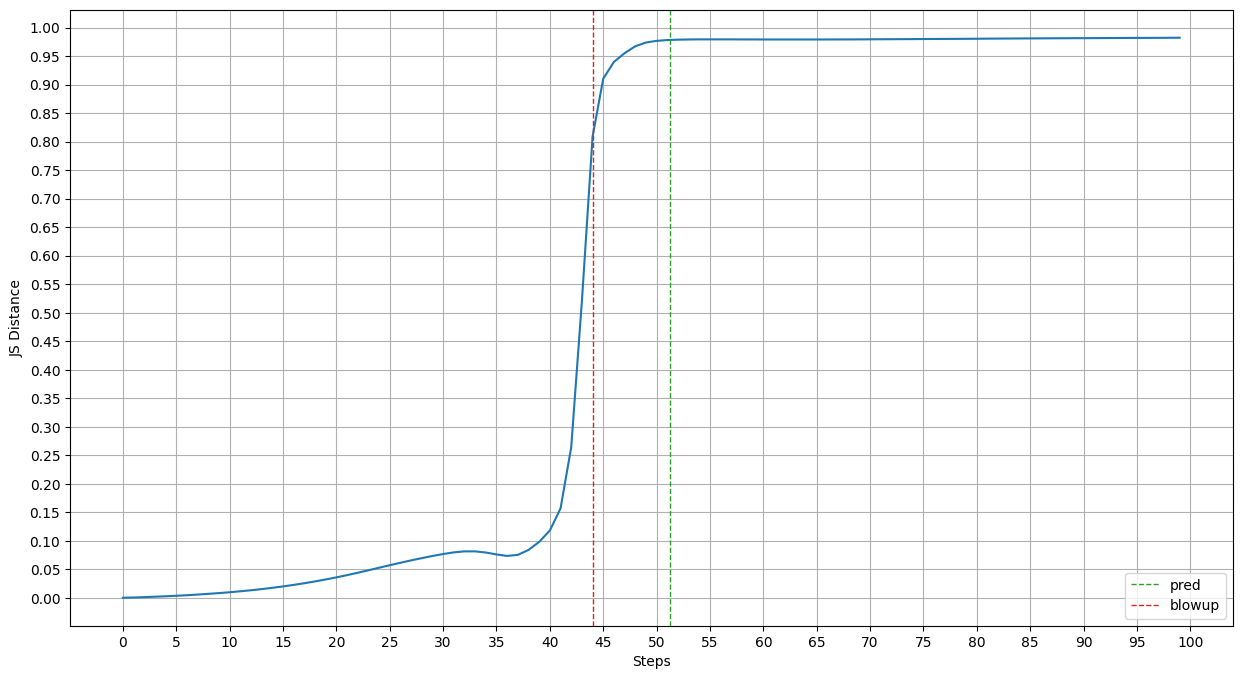

In [705]:
plt.figure(figsize=(15, 8))
plt.plot(step_js_dists)
plt.axvline(x=pred, color="tab:green", linestyle="--", linewidth=1, label="pred")

plt.axvline(
    x=js_blowup_step, color="tab:red", linestyle="--", linewidth=1, label="blowup"
)

plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 105, 5))
plt.xlabel("Steps")
plt.ylabel("JS Distance")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# plot_heatmap_feature_acts(feature_acts, step_js_dists)